In [1]:
from copy import deepcopy
import numpy as np
from random import shuffle
from itertools import product
from matplotlib import pyplot as plt

<h2><center> CSCI - UA 9472 - Artificial Intelligence </center></h2>

<h3><center> Assignment 3: Logical reasoning </center></h3>

<center>Given date: November 8 
</center>
<center><font color='red'>Due date: November 30 </font>
</center>
<center><b>Total: 40 pts </b>
</center>


<center>In this third assignment, we will implement a simple Logical agent by relying on the resolution algorithm of Propositional Logic.</center>

<img src="simpleVideoGameCave.jpeg" width="400" height="300"/>


### Introduction: logical propositions

The final objective will be to code our logical agent to succeed in a simple world similar to the Wumpus world discussed in the lectures. The final world we will consider is shown below.

<img src="MazeTotal.png" width="400" height="300"/>

Before designing the full agent, we will focus on a series of simplified environments (see below). In order to help you in your implementation, you are provided with the class 'Expr' and the associated function 'expr' which can be used to store and process logical propositions. The logical expressions are stored as objects consisting of an operator 'op' which can be of the types '&' (and), '|' (or) '==>' (implication) or '<=>' (double implication) as well as '~' (not). A logical expression such as 'A & B' can be stored as a string by means of the function expr() as expr('A & B') or Expr('&', 'A', 'B').

The function expr() takes operator precedence into account so that the two lines

In [2]:
'''source : AIMA'''

import collections

Number = (int, float, complex)
# Expression = (Expr, Number) # moved to lower part

def Symbol(name):
    """A Symbol is just an Expr with no args."""
    return Expr(name)


class Expr:
    """source: Artificial Intelligence: A Modern Approach
    A mathematical expression with an operator and 0 or more arguments.
    op is a str like '+' or 'sin'; args are Expressions.
    Expr('x') or Symbol('x') creates a symbol (a nullary Expr).
    Expr('-', x) creates a unary; Expr('+', x, 1) creates a binary."""
    
    def __init__(self, op, *args):
        self.op = str(op)
        self.args = args

    # Operator overloads
    def __neg__(self):
        return Expr('-', self)

    def __pos__(self):
        return Expr('+', self)

    def __invert__(self):
        return Expr('~', self)

    def __add__(self, rhs):
        return Expr('+', self, rhs)

    def __sub__(self, rhs):
        return Expr('-', self, rhs)

    def __mul__(self, rhs):
        return Expr('*', self, rhs)

    def __pow__(self, rhs):
        return Expr('**', self, rhs)

    def __mod__(self, rhs):
        return Expr('%', self, rhs)

    def __and__(self, rhs):
        return Expr('&', self, rhs)

    def __xor__(self, rhs):
        return Expr('^', self, rhs)

    def __rshift__(self, rhs):
        return Expr('>>', self, rhs)

    def __lshift__(self, rhs):
        return Expr('<<', self, rhs)

    def __truediv__(self, rhs):
        return Expr('/', self, rhs)

    def __floordiv__(self, rhs):
        return Expr('//', self, rhs)

    def __matmul__(self, rhs):
        return Expr('@', self, rhs)

    def __or__(self, rhs):
        """Allow both P | Q, and P |'==>'| Q."""
        if isinstance(rhs, Expression):
            return Expr('|', self, rhs)
        else:
            return PartialExpr(rhs, self)

    # Reverse operator overloads
    def __radd__(self, lhs):
        return Expr('+', lhs, self)

    def __rsub__(self, lhs):
        return Expr('-', lhs, self)

    def __rmul__(self, lhs):
        return Expr('*', lhs, self)

    def __rdiv__(self, lhs):
        return Expr('/', lhs, self)

    def __rpow__(self, lhs):
        return Expr('**', lhs, self)

    def __rmod__(self, lhs):
        return Expr('%', lhs, self)

    def __rand__(self, lhs):
        return Expr('&', lhs, self)

    def __rxor__(self, lhs):
        return Expr('^', lhs, self)

    def __ror__(self, lhs):
        return Expr('|', lhs, self)

    def __rrshift__(self, lhs):
        return Expr('>>', lhs, self)

    def __rlshift__(self, lhs):
        return Expr('<<', lhs, self)

    def __rtruediv__(self, lhs):
        return Expr('/', lhs, self)

    def __rfloordiv__(self, lhs):
        return Expr('//', lhs, self)

    def __rmatmul__(self, lhs):
        return Expr('@', lhs, self)

    def __call__(self, *args):
        """Call: if 'f' is a Symbol, then f(0) == Expr('f', 0)."""
        if self.args:
            raise ValueError('Can only do a call for a Symbol, not an Expr')
        else:
            return Expr(self.op, *args)

    # Equality and repr
    def __eq__(self, other):
        """x == y' evaluates to True or False; does not build an Expr."""
        return isinstance(other, Expr) and self.op == other.op and self.args == other.args

    def __lt__(self, other):
        return isinstance(other, Expr) and str(self) < str(other)

    def __hash__(self):
        return hash(self.op) ^ hash(self.args)

    def __repr__(self):
        op = self.op
        args = [str(arg) for arg in self.args]
        if op.isidentifier():  # f(x) or f(x, y)
            return '{}({})'.format(op, ', '.join(args)) if args else op
        elif len(args) == 1:  # -x or -(x + 1)
            return op + args[0]
        else:  # (x - y)
            opp = (' ' + op + ' ')
            return '(' + opp.join(args) + ')'


Expression = (Expr, Number)


def expr(x):
    """Shortcut to create an Expression. x is a str in which:
    - identifiers are automatically defined as Symbols.
    - ==> is treated as an infix |'==>'|, as are <== and <=>.
    If x is already an Expression, it is returned unchanged. Example:
    >>> expr('P & Q ==> Q')
    ((P & Q) ==> Q)
    """
    return eval(expr_handle_infix_ops(x), defaultkeydict(Symbol)) if isinstance(x, str) else x

def expr_handle_infix_ops(x):
    """Given a str, return a new str with ==> replaced by |'==>'|, etc.
    >>> expr_handle_infix_ops('P ==> Q')
    "P |'==>'| Q"
    """
    for op in infix_ops:
        x = x.replace(op, '|' + repr(op) + '|')
    return x

infix_ops = '==> <== <=>'.split()

class defaultkeydict(collections.defaultdict):
    """Like defaultdict, but the default_factory is a function of the key.
    >>> d = defaultkeydict(len); d['four']
    4
    """

    def __missing__(self, key):
        self[key] = result = self.default_factory(key)
        return result

    
class PartialExpr:
    """Given 'P |'==>'| Q, first form PartialExpr('==>', P), then combine with Q."""

    def __init__(self, op, lhs):
        self.op, self.lhs = op, lhs

    def __or__(self, rhs):
        return Expr(self.op, self.lhs, rhs)

    def __repr__(self):
        return "PartialExpr('{}', {})".format(self.op, self.lhs)



#### Question 1: to CNF (7pts)

Now that we can create a knowledge base, in order to implement the resolution algorithm that will ultimately enable our agent to leverage the information from the environment, we need our sentences to written in conjunctive normal form (CNF). That requires a number of steps which are recalled below:

- bicond elimination: $(\alpha \Leftrightarrow \beta) \equiv ((\alpha\Rightarrow \beta) \wedge (\beta \Rightarrow \alpha))$
- Implication elimination $\alpha \Rightarrow \beta \equiv \lnot \alpha \vee \beta$
- De Morgan's Law $\lnot (A\wedge B) = (\lnot A \vee \lnot B)$, $\lnot(\alpha \vee B) \equiv (\lnot A \wedge \lnot B)$
- Distributivity of $\vee$ over $\wedge$: $(\alpha \vee (\beta \wedge \gamma)) \equiv ((\alpha \vee \beta) \wedge (\alpha \vee \gamma))$

Relying on the function propositional_exp given above (to avoid having all the questions depend on question 1, we will now rely on this implementation from AIMA), complete the function below which should return the CNF of the logical propostion $p$.  

The functions I wrote to achieve CNF does not return anything. It computes everything in-place. 

In [3]:
# auxillary functions
def is_op_free(p,*ops):
    '''This checks if the sentence p is free from symbol in ops'''
    s = p.__repr__()
    return all([not op in s for op in ops])
    
def is_atomic(p):
    '''
    This checks if the sentence p is atomic. 
    i.e. expr('a') and expr('~a') are atomic
    '''

    return (p.args == ()) or \
        (p.op == '~' and len(p.args) == 1 and p.args[0].args == ())
        
def neg_inside(p):
    '''
    This checks if all the neg are moved to the inner level of the sentence p. 
    '''
    return is_atomic(p) or \
        (p.op != "~" and all([neg_inside(a) for a in p.args]))
        

def is_cnf_comp(p):
    '''
    This checks a sentence p is in a cnf component form. 
    Specifically, if p is disjunction of atomic symbols. 
    '''

    return (is_atomic(p)) or  \
        (p.op == "|" and all([is_atomic(a) for a in p.args]))


def is_cnf(p):
    '''
    This checks if sentence p is an cnf. 
    '''

    return (is_cnf_comp(p)) or \
        (p.op == '&' and all([is_cnf_comp(a) for a in p.args]))


def get_cnf_components(p):
    '''
    For a cnf p, return all its cnf components in a list
    '''

    assert(is_cnf(p))

    if is_cnf_comp(p):
        return [p]

    else:
        return list(p.args)


def get_component_symbols(p):
    '''
    For a cnf component, return all its atomic symbols in a list
    '''

    assert(is_cnf_comp(p))

    if is_atomic(p):
        return [p]

    else:
        return list(p.args)


In [4]:
def remove_bicond(p):
    '''This removes the <=> symbol in a sentence'''
    
    if is_op_free(p,'<=>'):
        return 

    for arg in p.args:
        remove_bicond(arg)
    
    if p.op == '<=>':
        assert(len(p.args) == 2)
        l,r, = p.args
        p.op = '&'
        p.args = (Expr('==>', l, r), Expr('==>', r, l))
        return

def remove_impl(p):
    '''
    This removes the ==> in the sentence p. 
    '''
    assert(is_op_free(p,'<=>'))
    
    if is_op_free(p, '==>'):
        return 
    
    for i in p.args:
        remove_impl(i)
    
    if p.op == '==>':
        assert(len(p.args) == 2)
        l, r = p.args
        p.op = '|'
        p.args = (Expr('~',l), Symbol(r))

def move_neg(p):
    '''
    This moves the negation so that it only appears in the atomic level. 
    '''

    assert(is_op_free(p,'==>','<=>'))
    
    if is_atomic(p):
        return 

    if p.op == '~':
        assert(len(p.args) == 1)
        a, = p.args
        
        assert(a.op in ['~','|','&'])
        
        if a.op == '~':
            # cancelling double negation
            assert(len(a.args)==1)
            try:
                p.op = a.args[0].op
                p.args = a.args[0].args
            except AttributeError:
                # sometimes it happens that a.args[0] has not args attribute, which is quite buggy. 
                p.op = a.args[0]
                p.args = ()
        else:
            p.args = tuple([Expr('~', i) for i in a.args])
            if a.op == '|': p.op = '&'
            else: p.op = '|'

    for i in p.args: 
        move_neg(i)

it could be tricky to apply the distribution law. So I better document it here. 

The general rules are:
- if p is atomic, then do nothing
- if p is conjunction of CNF, then just lift each args of the CNF
- if p is disjunction of 2 CNF, then apply the distribution law as following

For two conjunctive normal forms $CNF_1 = \wedge_i (CNF_{1,i}), CNF_2 = \wedge_j (CNF_{2,j})$, where each of $CNF_{1,i},CNF_{2,j}$ are just disjunction of atomic symbols. I can have the following calculation 

$$
CNF_1 \vee CNF_2 \\
= (\wedge_i CNF_{1,i} ) \vee CNF_2 \\
= \wedge_i (CNF_{1,i} \vee CNF_2) \\
= \wedge_i (CNF_{1,i} \vee (\wedge_j CNF_{2,j} )) \\
= \wedge_i (\wedge_j (CNF_{1,i} \vee CNF_{2,j}) ) \\
= \wedge_{i,j} (CNF_{1,i} \vee CNF_{2,j})
$$

More generally, disjunction of $n$ CNFs can be computed as 

$$
CNF_1 \vee CNF_2 \vee \cdots \vee CNF_n \\
= \wedge_{i_1,i_2, i_n} (CNF_{1,i_1} \vee CNF_{2,i_2} \vee \cdots \vee CNF_{n,i_n}) \\
= \wedge_{i_1,i_2, i_n} ( \vee_{t=1}^n CNF_{t,i_t}) \\
$$

- Also, one should remove repeated atomic symbols whenever possible. 


In [5]:
def move_or(p):
    assert(is_op_free(p, "<=>", "==>") and neg_inside(p))
    
    if is_cnf(p):
        return
    
    for a in p.args:
        move_or(a)
    # now we can suppose all the args of p are cnf. 
    
    if p.op == '&':
        # conjunction of CNF.
        print(1)

        new_args = []
        for i in get_cnf_components(p):
            new_args.extend(i)
        p.args = tuple(new_args)
        
        return
    
    
    elif p.op == '|':
        # disjunction of CNFs,
        dis_components = []
        
        for a in p.args:
            dis_components.append(get_cnf_components(a))
        
        # using itertools.product to produce the result. 
        
        new_args = []
        for i in product(*dis_components):
            new_symbols = []
            
            for j in i:
                new_symbols.extend(get_component_symbols(j))
            new_args.append(Expr("|", *new_symbols))
        
        p.op = "&"
        p.args = tuple(new_args)


In [6]:
def clean_and_sort_cnf_comp(p):
    '''
    This will reorder the symbols in a cnf components with respect to some order, 
    Notice that `expr('~c') > expr('c')` is evaluate to True. 
    it means that we can always let the negative symbols to appear in the later part.
    
    An additional thing to to is filtering out component with both the symbol `a` and `~a`. Because by law of excluding the middle, such sentence is always true, therefore provide us with no information at all. 
    '''

    assert(is_cnf_comp(p))
    
    if is_atomic(p):
        return
    
    # setting up the symbols.
    symbols = sorted(list(set(get_component_symbols(p))))
    
    # setting the index, and return False for having "a or not a". 
    flag = True
    pos = []
    
    for i, s in enumerate(symbols):
        if flag:
            if s.op == '~':
                flag = False
            else:
                pos.append(str(s.op))
        
        if not flag:
            if str(s)[1:] in pos:
                return 'This sentence is meaningless'
    
    p.args = tuple(symbols)


def clean_and_sort_cnf(p):
    '''
    This function sort the cnf with respect to some order. 
    This will perhaps speed the resolution later. 
    '''
    
    assert(is_cnf(p))
    
    if is_atomic(p):
        return
    
    new_comps = [a for a in get_cnf_components(p) \
        if clean_and_sort_cnf_comp(a) != 'This sentence is meaningless']
    
    new_comps = tuple(sorted(list(set(new_comps))))
    
    if len(new_comps) == 0:
        return 'This sentence is meaningless'
    elif len(new_comps) == 1:
        a = new_comps[0]
        if is_atomic(a) and a.op != '~':
            p.args = ()
            p.op = a.op
        else:
            p.op = a.op
            p.args = a.args
        
    else:
        p.args = new_comps


In [7]:
def to_CNF(p):
    
    '''function should return the CNF of proposition p'''
    
    remove_bicond(p)
    remove_impl(p)
    move_neg(p)
    move_or(p)
    clean_and_sort_cnf(p)

An example of how my `to_CNF` works

In [8]:
t = expr("~(a<=>b)")
to_CNF(t)
print(t)

((a | b) & (~a | ~b))


#### Question 2: The resolution rule (7pts)

Now that you have a function that can turn any logical sentence to a CNF, we will code the resolution rule. For any two propositions $p_1$ and $p_2$ written in conjunctive normal form, write a function Resolution that returns empty if the resolution rule applied to the two sentences cannot produce any new sentence and that returns the set of all propositions $p_i$ following from the resolution of $p_1$ and $p_2$ otherwise.  

Study the disjuncts of both $p_1$ and $p_2$. For each of the disjunct in $p_1$ try to find in $p_2$ the negation of that disjunct. If this negation appears, returns the proposition resulting from combining $p_1$ and $p_2$ with a disjunction. 

In [9]:
def resolution_rule(p1, p2):
    
    '''applies the resolution rule on two propositions p1 and p2'''
    
    assert(is_cnf_comp(p1) and is_cnf_comp(p2))
    
    p1s = set(get_component_symbols(p1))
    p2s = set(get_component_symbols(p2))
    
    p1pos = set([str(i) for i in p1s if i.op !='~'])
    p1neg = set([str(i)[1:] for i in p1s if i.op == '~'])
    
    p2pos = set([str(i) for i in p2s if i.op != '~'])
    p2neg = set([str(i)[1:] for i in p2s if i.op == '~'])
    
    if len(p1pos & p2neg) == 0 and len(p2pos & p1neg) == 0:
        return 'nothing to resolve'
    
    total_pos = (p1pos - p2neg) | (p2pos - p1neg) 
    total_neg = (p1neg - p1pos) | (p2neg - p1pos) 
    
    if len(total_pos & total_neg):
        return "This sentence is meaningless"
    
    args = [expr(i) for i in sorted(list(total_pos))] \
        + [expr('~'+i) for i in sorted(list(total_neg))]
    
    if len(args) == 1:
        return Symbol(*args)
    if len(args) == 0:
        return expr('()')
    
    return Expr("|", *args)

#### Question 3: The resolution algorithm (6pts)

Now that we have a resolution function we can embed it into a resolution algorithm. Complete the function Resolution below which implements the resolution algorithm. The algorithm takes as input a knowledge base written in conjunctive normal form, and a proposition $\alpha$ and should return true or false (as stored in the variable 'is_entailed') depending on whether $\alpha$ is entailed by the knowledge base KB.

In [75]:
def sign_and_abs(p):
    assert(is_atomic(p))
    if p.op == '~':
        return str(p)[1:], False
    else:
        return str(p), True
        
def to_another_form(p):
    assert(is_cnf_comp(p))
    return {k:v for k,v in map(sign_and_abs, get_component_symbols(p))}
    
def back_to_cnf_comp(form):
    
    args = []
    
    for k,v in form.items():
        if v:
            args.append(expr(k))
        else:
            args.append(expr("~" + k))
    
    args = sorted(args)
    
    if len(args) == 0:
        return expr('()')
    if len(args) == 1:
        return args[0]
    else:
        return Expr("|",*args)

In [76]:
class KnowledgeBase:
    def __init__(self, *props):
        self.records = {}
        # records store all the knowledge
        self.symbols = {}
        # symbols store all the knowledge of an atomic symbol. 
        
        if len(props) == 1:
            self.learn(props[0])
        elif len(props) == 0:
            pass
        else:
            p = Expr("&", *props)
            self.learn(p)
    
    def learn(self,p):
        if to_CNF(p) != "This sentence is meaningless":
            for i in get_cnf_components(p):
                
                # self.records[str(i)] == i
                
                if is_atomic(i):
                    
                    symbol,sign = sign_and_abs(i)
                    
                    if symbol in self.symbols:
                        if sign == self.symbols[symbol]:
                            pass
                        else:
                            print('The knowledge base crashed for learning contradictory truth')
                            assert(False)
                    else:
                        self.symbols[symbol] = sign
                        
                        # Now, I am updating the record according to the new symbol.
                        
                        same_records = [k for k,v in self.records.items() \
                            if i in get_component_symbols(v)]
                        
                        for k in same_records:
                            self.records.pop(k) 
                        
                        ni = Expr("~",i)
                        move_neg(ni)
                        
                        different_records = [k for k,v in self.records.items() \
                            if ni in get_component_symbols(v)]
                        
                        for k in different_records:
                            record = self.records.pop(k)
                            args = [t for t in get_component_symbols(record) if t != ni]
                            if len(args) == 0:
                                assert(False)
                            if len(args) == 1:
                                self.learn(args[0])
                            else:
                                new_record = Expr("|", *args)
                                self.records[str(new_record)] = new_record
                    
                else:
                    record = to_another_form(i)
                    reducible = set(record.keys()) & set(self.symbols.keys())
                    if reducible:
                        if any([record[k]==self.symbols[k] for k in reducible]):
                            continue
                        else:
                            for k in reducible:
                                record.pop(k)
                    i = back_to_cnf_comp(record)
                
                self.records[str(i)] = i
    
    def check_entailment(self, alpha):
        
        if is_atomic(alpha):
            symb, s = sign_and_abs(alpha)
            if symb in self.symbols:
                return s == self.symbols[symb]
        
        if KB.resolution(alpha):
            self.learn(alpha)
            return True
        else:
            return False
        
    def resolution(self, alpha):
        
        all_records = deepcopy(self.records)
        
        new_sentence = Expr("~",alpha)
        if to_CNF(new_sentence) == "This sentence is meaningless":
            return False
        
        new_records = {str(i):i for i in get_cnf_components(new_sentence)}
        
        all_records.update(new_records)
        
        queue = product(all_records.values(),all_records.values())
        
        new_records = dict()
        
        while True:
            try: 
                p1,p2 = next(queue)
                
                res = resolution_rule(p1,p2)
                
                if res in ['nothing to resolve', "This sentence is meaningless"]:
                    continue
                
                if res == expr('()'):
                    return True
                
                if str(res) not in all_records.keys():
                    new_records[str(res)] = res
                    all_records[str(res)] = res
            
            except StopIteration:
                if len(new_records):
                    queue = product(new_records.values(),all_records.values())
                    new_records = dict()
                else:
                    return False


#### Question 4 (8pts): A first logical agent

Given our resolution algorithm, we will finally be able to design our first logical agent. As a first step, we consider a simple agent located on the bottom left cell of a 5 by 5 grid world. The world contains a single threat represented by a ghost which occupies a single cell and emits a loud noise ('OOooo') audible in the immediately adjacent cells. 

To implement the agent, we will use the following approach:

Each cell will be represented by its (x,y) coordinate ((0,0) being the bottom leftmost cell). On top of this we will consider the following symbols 

- $D_{(x, y)}$ (which you can store as the string 'Dxy' or 'D_xy' as you want) indicating whether there is an **exit** on the cell or not (when the agent reach the exit, the simulation ends), 

- $G_{(x, y)}$ which encodes whether the **ghost** is located on cell $(x, y)$ or not

- $O_{(x, y)}$ which encodes whether a "Ooooo" is **heard** on the cell $(x, y)$

Using those three symbols, the state of the world can be defined with a total of 3*25 symbols. 

In a while loop running until the door is found, code a simple logical agent that moves at random in the non-threatening cells until it finds the escape cell. Also consider the following:

- The agent should keep track of a knowledge base KB (list of logically true propositions together with a dictionnary storing the symbols that are known to be true) including all the sentences that the agent can generate based on the information it collected at the previous steps. 


- You might want to have a simple function, which given a symbol returns the adjacent symbols (symbols corresponding to spatially adjacent cells). you can store those as strings


- The agent should be equipped with the resolution algorithm that you coded above. Before each new move, the next cell should be determined at random (from the set of all non visited cells) and the agent should use the resolution algorithm to determine whether the ghost is on the cell or not. If there is no indication that the ghost is located on the cell, the agent should make the move. 

<img src="MazeGhostb.png" width="400" height="300"/>

In [91]:
def adjacent_cells(pos):
    x, y = pos
    adj = []
    if x > 0:
        adj.append((x-1, y))
    if x < 4:
        adj.append((x+1, y))
    if y > 0:
        adj.append((x, y-1))
    if y < 4:
        adj.append((x, y+1))
    shuffle(adj) # this steps gaurantee that the next step is at random
    return adj
    
def adj_cells_multiple(poss):
    ret = []
    for pos in poss:
        ret.extend(adjacent_cells(pos))
    return list(set(ret))
        
def pos2str(pos):
    return '_' + str(pos[0]) + '_' + str(pos[1])

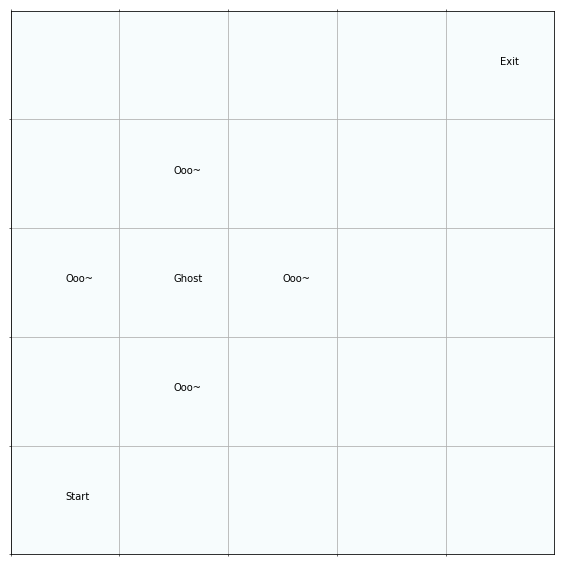

In [138]:
# Environment set up

world = np.zeros((5, 5))

# special positions
ghosts = [(1, 2)]
noises = adj_cells_multiple(ghosts)
exit = (4, 4)
start = (0, 0)

# ploting
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(world, cmap=plt.cm.BuGn)


ax.set_xticks(np.arange(world.shape[0])-0.5, minor='true')
ax.set_yticks(np.arange(world.shape[1])-0.5, minor='true')
ax.grid(which='minor')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.xlim((-0.5, world.shape[0]-0.5))
plt.ylim((-0.5, world.shape[1]-0.5))
plt.grid()

for g in ghosts:
    ax.text(*g, 'Ghost')
for n in noises:
    ax.text(*n, 'Ooo~')
ax.text(*exit, 'Exit')
ax.text(*start,'Start')

print()


In [100]:
# learning priori knowledge, the rules of this game. 
ghost_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            ghost_rules.append(expr('Ghost' + pos2str(pos) + '==> Ooo'+pos2str(adj)))

KB = KnowledgeBase(*(ghost_rules))

In [101]:
exitNotFound = True
curr_pos = start
path = []

while exitNotFound:

    '''Agent should explore the world at random, probing the 
    knowledge base for any potential threat. if the KB does not 
    indicate any specific threat, the agent should move in one of 
    the adacent (cleared) cell. The simulation ends when the agent 
    reaches the exit door'''
    # recording the path. 
    path.append(curr_pos)
    # stopping
    if curr_pos in ghosts:
        
        print('game over, killed by the ghost. ')
        break

    if curr_pos == exit:
        print("game won, find the exit")
        break
    
    # learning from current position
    
    suffix = pos2str(curr_pos)
    
    if curr_pos in noises:
        KB.learn(expr('Ooo' + suffix))
    else:
        KB.learn(expr('~Ooo' + suffix))
        
    # picking next step randomly
    for next_pos in adjacent_cells(curr_pos):
        # check if its safe
        if KB.check_entailment(expr('~Ghost' + pos2str(next_pos))):
            curr_pos = next_pos
            break


game won, find the exit


In [135]:
"~Six_0_2" in KB.records.keys()

True

In [102]:
print(path,sep='  ')

[(0, 0), (0, 1), (0, 2), (0, 1), (1, 1), (0, 1), (0, 2), (0, 1), (1, 1), (1, 0), (2, 0), (1, 0), (2, 0), (2, 1), (1, 1), (1, 0), (0, 0), (1, 0), (1, 1), (1, 0), (0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (3, 2), (3, 1), (2, 1), (3, 1), (3, 2), (2, 2), (3, 2), (3, 1), (3, 0), (3, 1), (2, 1), (2, 0), (2, 1), (1, 1), (0, 1), (1, 1), (0, 1), (0, 2), (0, 1), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (2, 0), (1, 0), (1, 1), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 1), (2, 1), (2, 2), (2, 1), (1, 1), (1, 0), (1, 1), (0, 1), (0, 0), (0, 1), (1, 1), (1, 0), (0, 0), (1, 0), (2, 0), (3, 0), (2, 0), (2, 1), (1, 1), (2, 1), (2, 2), (2, 1), (2, 0), (2, 1), (2, 0), (3, 0), (2, 0), (2, 1), (2, 2), (2, 1), (1, 1), (1, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 1), (3, 1), (4, 1), (4, 0), (3, 0), (4, 0), (4, 1), (3, 1), (3, 0), (3, 1), (4, 1), (4, 2), (4, 3), (3, 3), (3, 4), (3, 3), (2, 3), (2, 2), (2, 3), (2, 4), (2, 3), (2, 2), (3, 2), (4, 2), (4, 1), (4, 2),

It took about 15-20 minutes for my first implementation of the KB to finish the first game. 
For the second implementation, I have delibrately designed a `learn` function for the class KB. And now it finishes this game within 0.5 second. 
**SUPER FAST**

#### Question 5: Getting used to danger.. (6pts)

Now that our agent knows how to handle a ghost, we will increase the level of risk by including spike traps in the environment. 

- Our agent has an edge: evolution has endowed it with a sort of additional ($6^{th}$) sense so that it can feel something 'bad' is about to happen when it is in a cell adjacent to a trap. We represent this ability with the eye combined with the exclamation mark. 


- Since, as we all know, ghosts are purely imaginary entities, the $6th$ sense only works for the spike traps.  


- The ghost can still be located by means of the noise it generates which can be heard on all adjacent cells.

<img src="MazeTrapb.png" width="400" height="300"/>

Starting from the agent you designed in the previous questions, improve this agent so that it takes into account the spike traps. You should now have a knowledge base defined on a total of 25*5 symbols describing whether each cell contains a ghost, a 'OOoo' noise, a spike trap, activated the agent's'6th sense', or contains the exit door. The search ends when the agent reaches the door.   

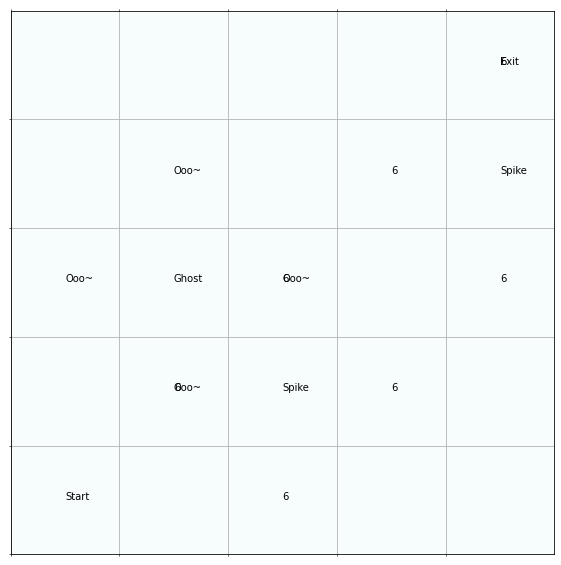

In [131]:
# Environment set up

world = np.zeros((5, 5))

# special positions
ghosts = [(1, 2)]
noises = adj_cells_multiple(ghosts)

spikes = [(2,1),(4,3)]
six_senses = adj_cells_multiple(spikes)

exit = (4, 4)
start = (0, 0)

# ploting
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(world, cmap=plt.cm.BuGn)

ax.set_xticks(np.arange(world.shape[0])-0.5, minor='true')
ax.set_yticks(np.arange(world.shape[1])-0.5, minor='true')
ax.grid(which='minor')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.xlim((-0.5, world.shape[0]-0.5))
plt.ylim((-0.5, world.shape[1]-0.5))
plt.grid()

for g in ghosts:
    ax.text(*g, 'Ghost')
for n in noises:
    ax.text(*n, 'Ooo~')
    
for s in spikes:
    ax.text(*s, 'Spike')
for s in six_senses:
    ax.text(*s, '6')

ax.text(*exit, 'Exit')
ax.text(*start,'Start')
print()

In [132]:
# learning priori knowledge, the rules of this game. 
ghost_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            ghost_rules.append(expr('Ghost' + pos2str(pos) + '==> Ooo'+pos2str(adj)))

spike_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            spike_rules.append(
                expr('Spike' + pos2str(pos) + '==> Six'+pos2str(adj)))

KB = KnowledgeBase(*(ghost_rules+spike_rules))

In [133]:
exitNotFound = True
curr_pos = start
path = []

max_Iter = 1000

while exitNotFound and max_Iter > 0:

    '''Agent should explore the world at random, probing the 
    knowledge base for any potential threat. if the KB does not 
    indicate any specific threat, the agent should move in one of 
    the adacent (cleared) cell. The simulation ends when the agent 
    reaches the exit door'''
    # recording the path. 
    path.append(curr_pos)
    max_Iter += -1
    
    if len(path)%10 == 0:
        print(path[-10:],sep='  ')
        
    # stopping
    if curr_pos in ghosts:
        print('game over, killed by the ghost. ')
        break
    if curr_pos in spikes:
        print('game over, killed by the spike. ')
    if curr_pos == exit:
        print("game won, find the exit")
        break
    
    # learning from current position
    
    suffix = pos2str(curr_pos)
    
    if curr_pos in noises:
        KB.learn(expr('Ooo' + suffix))
    else:
        KB.learn(expr('~Ooo' + suffix))
    
    if curr_pos in six_senses:
        KB.learn(expr("Six" + suffix))
    else:
        KB.learn(expr("~Six" + suffix))
    
    # picking next step randomly
    
    for next_pos in adjacent_cells(curr_pos):
        # check if its safe
        if KB.check_entailment(expr('~Ghost' + pos2str(next_pos))) and KB.check_entailment(expr('~Spike' + pos2str(next_pos))):
            curr_pos = next_pos
            break


[(0, 0), (0, 1), (0, 2), (0, 1), (1, 1), (0, 1), (0, 2), (0, 1), (1, 1), (0, 1)]
[(0, 0), (1, 0), (1, 1), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 1)]
[(1, 1), (0, 1), (0, 2), (0, 1), (1, 1), (0, 1), (0, 2), (0, 1), (0, 2), (0, 1)]
[(0, 2), (0, 1), (1, 1), (1, 0), (1, 1), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0)]
[(1, 1), (1, 0), (1, 1), (0, 1), (0, 2), (0, 1), (0, 2), (0, 1), (1, 1), (0, 1)]
[(0, 2), (0, 1), (0, 2), (0, 1), (0, 2), (0, 1), (0, 2), (0, 1), (1, 1), (1, 0)]
[(1, 1), (0, 1), (1, 1), (0, 1), (1, 1), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0)]
[(1, 1), (0, 1), (1, 1), (1, 0), (1, 1), (0, 1), (0, 0), (0, 1), (0, 0), (0, 1)]
[(1, 1), (0, 1), (0, 2), (0, 1), (0, 2), (0, 1), (0, 0), (0, 1), (0, 0), (1, 0)]
[(2, 0), (1, 0), (2, 0), (1, 0), (0, 0), (1, 0), (1, 1), (1, 0), (2, 0), (1, 0)]
[(0, 0), (0, 1), (1, 1), (1, 0), (2, 0), (1, 0), (1, 1), (0, 1), (0, 2), (0, 1)]
[(0, 2), (0, 1), (1, 1), (1, 0), (2, 0), (1, 0), (1, 1), (1, 0), (0, 0), (1, 0)]
[(2, 0), (1, 0), (1, 1), (0,

In [139]:
set(path)

{(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)}

We can see that after 1000 iterations, the agent still cannot escape. There is **nothing wrong** with the algorithm, however. Because there is another world that will give the agent similar percept sequence, and that world is unescapable. 

The two worlds and the perception of the agent can be seen in the comparison of the following 2 graphs

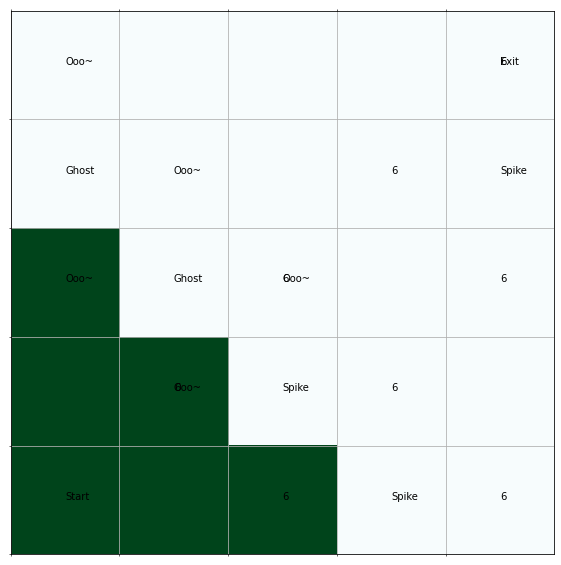

In [142]:
# unescapable world

world = np.zeros((5, 5))

for pos in path:
    world[pos] = 1
# special positions
ghosts = [(1, 2),(0,3)]
noises = adj_cells_multiple(ghosts)

spikes = [(2,1),(3,0),(4,3)]
six_senses = adj_cells_multiple(spikes)

exit = (4, 4)
start = (0, 0)

# ploting
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(world, cmap=plt.cm.BuGn)

ax.set_xticks(np.arange(world.shape[0])-0.5, minor='true')
ax.set_yticks(np.arange(world.shape[1])-0.5, minor='true')
ax.grid(which='minor')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.xlim((-0.5, world.shape[0]-0.5))
plt.ylim((-0.5, world.shape[1]-0.5))
plt.grid()

for g in ghosts:
    ax.text(*g, 'Ghost')
for n in noises:
    ax.text(*n, 'Ooo~')
    
for s in spikes:
    ax.text(*s, 'Spike')
for s in six_senses:
    ax.text(*s, '6')

ax.text(*exit, 'Exit')
ax.text(*start,'Start')
print()

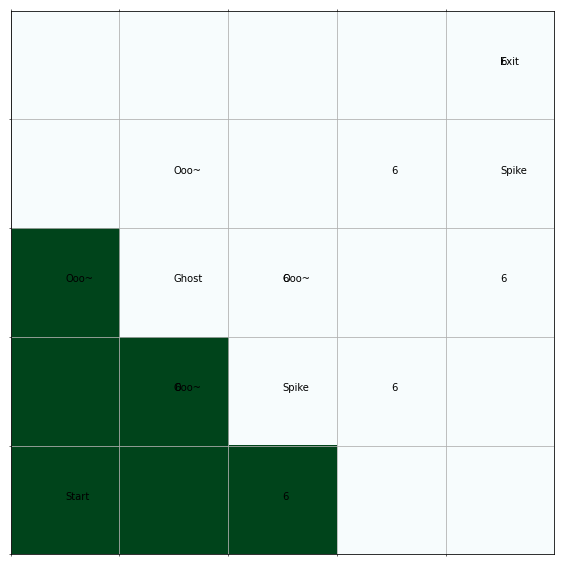

In [143]:
# escapable world

world = np.zeros((5, 5))

for pos in path:
    world[pos] = 1
# special positions
ghosts = [(1, 2)]
noises = adj_cells_multiple(ghosts)

spikes = [(2,1),(4,3)]
six_senses = adj_cells_multiple(spikes)

exit = (4, 4)
start = (0, 0)

# ploting
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(world, cmap=plt.cm.BuGn)

ax.set_xticks(np.arange(world.shape[0])-0.5, minor='true')
ax.set_yticks(np.arange(world.shape[1])-0.5, minor='true')
ax.grid(which='minor')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.xlim((-0.5, world.shape[0]-0.5))
plt.ylim((-0.5, world.shape[1]-0.5))
plt.grid()

for g in ghosts:
    ax.text(*g, 'Ghost')
for n in noises:
    ax.text(*n, 'Ooo~')
    
for s in spikes:
    ax.text(*s, 'Spike')
for s in six_senses:
    ax.text(*s, '6')

ax.text(*exit, 'Exit')
ax.text(*start,'Start')
print()

#### Bonus: For where your treasure is..  (6pts)

We finally consider the whole environment. This environment is composed of all the elements from the previous questions but it now also includes a treasure chest. The final objective this time is to find the chest first and then reach the exit. Although some of the previous symbols are omitted for clarity, the ghost can always be located by means of the sound it produces, the agent can still trust its $6^{\text{th}}$ sense regarding the spike trap and the treasure chest can be perceived in adjacent cells, by means of the shine it produces.

When the knowledge base does not indicate any threat, the agent should move at random in one of the adjacent cells. 

The world now contains a total of 25*7 symbols. 


<img src="fullWorldChest.png" width="400" height="300"/>

For the similar reason in the previous problem, this world is still **inescapable** for an agent requiring complete safety. 

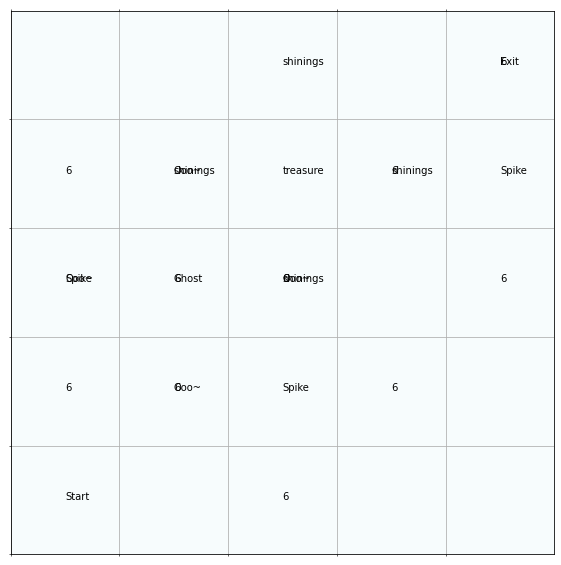

In [150]:
# Environment set up

world = np.zeros((5, 5))

# special positions
ghosts = [(1, 2)]
noises = adj_cells_multiple(ghosts)

spikes = [(2,1),(4,3),(0,2)]
six_senses = adj_cells_multiple(spikes)

treasures = [(2,3)]
shinings = adj_cells_multiple(treasures)

exit = (4, 4)
start = (0, 0)

# ploting
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(world, cmap=plt.cm.BuGn)

ax.set_xticks(np.arange(world.shape[0])-0.5, minor='true')
ax.set_yticks(np.arange(world.shape[1])-0.5, minor='true')
ax.grid(which='minor')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
plt.xlim((-0.5, world.shape[0]-0.5))
plt.ylim((-0.5, world.shape[1]-0.5))
plt.grid()

for g in ghosts:
    ax.text(*g, 'Ghost')
for n in noises:
    ax.text(*n, 'Ooo~')
    
for s in spikes:
    ax.text(*s, 'Spike')
for s in six_senses:
    ax.text(*s, '6')

for s in treasures:
    ax.text(*s,'treasure')
for s in shinings:
    ax.text(*s,'shinings')

ax.text(*exit, 'Exit')
ax.text(*start,'Start')
print()

In [151]:
# learning priori knowledge, the rules of this game. 
ghost_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            ghost_rules.append(expr('Ghost' + pos2str(pos) + '==> Ooo'+pos2str(adj)))

spike_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            spike_rules.append(
                expr('Spike' + pos2str(pos) + '==> Six'+pos2str(adj)))

treasure_rules = []
for x in range(5):
    for y in range(5):
        pos = (x, y)
        for adj in adjacent_cells(pos):
            treasure_rules.append(
                expr('Treasure' + pos2str(pos) + '==> Shine'+pos2str(adj)))
            treasure_rules.append(
                expr('Treasure' + pos2str(pos) + '==> Got_treasure'))
KB = KnowledgeBase(*(ghost_rules+spike_rules))


In [152]:
exitNotFound = True
curr_pos = start
path = []

max_Iter = 1000

while exitNotFound and max_Iter > 0:

    '''Agent should explore the world at random, probing the 
    knowledge base for any potential threat. if the KB does not 
    indicate any specific threat, the agent should move in one of 
    the adacent (cleared) cell. The simulation ends when the agent 
    reaches the exit door'''
    # recording the path. 
    path.append(curr_pos)
    max_Iter += -1
    
    if len(path)%10 == 0:
        print(path[-10:],sep='  ')
        
    # stopping
    if curr_pos in ghosts:
        print('game over, killed by the ghost. ')
        break
    if curr_pos in spikes:
        print('game over, killed by the spike. ')
    if curr_pos == exit:
        if KB.check_entailment(expr("Got_treasure")):
            print("game won, find the exit")
            break
    
    # learning from current position
    
    suffix = pos2str(curr_pos)
    
    if curr_pos in noises:
        KB.learn(expr('Ooo' + suffix))
    else:
        KB.learn(expr('~Ooo' + suffix))
    
    if curr_pos in six_senses:
        KB.learn(expr("Six" + suffix))
    else:
        KB.learn(expr("~Six" + suffix))
    
    if curr_pos in shinings:
        KB.learn(expr("Shine" + suffix))
    else:
        KB.learn(expr("~Shine" + suffix))
    
    # picking next step randomly
    
    for next_pos in adjacent_cells(curr_pos):
        # check if its safe
        if KB.check_entailment(expr('~Ghost' + pos2str(next_pos))) and KB.check_entailment(expr('~Spike' + pos2str(next_pos))):
            curr_pos = next_pos
            break


[(0, 0), (1, 0), (1, 1), (1, 0), (0, 0), (0, 1), (0, 0), (0, 1), (1, 1), (0, 1)]
[(1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (2, 0), (1, 0), (1, 1), (1, 0)]
[(1, 1), (1, 0), (2, 0), (1, 0), (0, 0), (0, 1), (1, 1), (1, 0), (1, 1), (1, 0)]
[(1, 1), (0, 1), (1, 1), (1, 0), (1, 1), (0, 1), (0, 0), (1, 0), (0, 0), (1, 0)]
[(2, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 1), (1, 0)]
[(2, 0), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 1), (0, 1), (0, 0), (1, 0)]
[(0, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0)]
[(1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (0, 0), (0, 1), (0, 0), (1, 0)]
[(2, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0)]
[(1, 1), (1, 0), (2, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (0, 1)]
[(0, 0), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0), (0, 0), (0, 1), (1, 1), (0, 1)]
[(1, 1), (1, 0), (0, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0), (2, 0), (1, 0)]
[(0, 0), (0, 1), (1, 1), (0,